In [109]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_tools import Source_present, Photometry, Scale_model, Oldest_galaxy,Smooth
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [2]:
def Smooth(f,x):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    fx = ksmooth.locpoly(x,f,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [166]:
def Stack(wv,flgrid,errgrid,contam):
#     for i in range(len(flgrid)):
#         flgrid[i][contam[i]**2 / (errgrid[i]**2 - contam[i]**2) > 1] = 0
#         errgrid[i][contam[i]**2 / (errgrid[i]**2 - contam[i]**2) > 1] = 1E5
    
    
    flgrid = np.transpose(flgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    
    return stack, err

In [4]:
class Get_groups(object):
    def __init__(self, galaxy_id, field):
        self.galaxy_id = galaxy_id
        self.field = field
    
        if self.field == 'GSD':
            if hpath.strip('/Users/') == 'Vince.ec':
                self.mosaic = '/Volumes/Vince_research/Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits'
                self.catalog = '/Volumes/Vince_research/Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sub.cat'
            if hpath.strip('/Users/') == 'vestrada':
                self.mosaic = hpath + 'Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits'
                self.catalog = hpath + 'Data/CLEAR/CATALOGS/goodss_v4.4/goodss-F105W-astrodrizzle-v4.4_drz_sub.cat'

            self.seg_map = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits'
            self.flt_path_g102 = hpath + 'Clear_data/s_flt_files/'
            self.flt_path_g141 = hpath + '3dhst/s_flt_files/'
            self.ref_cat_loc = Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()

        if self.field == 'GND':
            if hpath.strip('/Users/') == 'Vince.ec':
                self.mosaic = '/Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_v4.4/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
                self.catalog = '/Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_v4.4/goodsn-F105W-astrodrizzle-v4.4_drz_sub.cat'
            if hpath.strip('/Users/') == 'vestrada':
                self.mosaic = hpath + 'Data/CLEAR/CATALOGS/goodsn_v4.4/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
                self.catalog = hpath + 'Data/CLEAR/CATALOGS/goodsn_v4.4/goodsn-F105W-astrodrizzle-v4.4_drz_sub.cat'

            self.seg_map = hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.seg.fits'
            self.flt_path_g102 = hpath + 'Clear_data/n_flt_files/'
            self.flt_path_g141 = hpath + '3dhst/n_flt_files/'
            self.ref_cat_loc = Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

        self.galaxy_ra = float(self.ref_cat_loc['ra'][self.ref_cat_loc['id'] == self.galaxy_id])
        self.galaxy_dec = float(self.ref_cat_loc['dec'][self.ref_cat_loc['id'] == self.galaxy_id])
        self.ref_cat = Table.read(self.catalog,format='ascii')


        flt_files = glob(self.flt_path_g102 + '*')

        self.grism_flts = []
        self.Bflts = []
        for i in flt_files:
            in_flt,loc = Source_present(i,self.galaxy_ra,self.galaxy_dec)
            if in_flt:
                self.grism_flts.append(i)
                self.Bflts.append(i)

        flt_files = glob(self.flt_path_g141 + '*')

        self.Rflts = []
        for i in flt_files:
            in_flt,loc = Source_present(i,self.galaxy_ra,self.galaxy_dec)
            if in_flt:
                self.grism_flts.append(i)
                self.Rflts.append(i)

        self.grp = multifit.GroupFLT(grism_files = self.grism_flts, direct_files = [], 
                      ref_file = self.mosaic,
                      seg_file = self.seg_map,
                      catalog = self.ref_cat,
                      cpu_count = 2,verbose = False)

        self.grp.compute_full_model(mag_limit=25)
        self.grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

        self.beams = self.grp.get_beams(self.galaxy_id, size=80)
        self.mb = multifit.MultiBeam(self.beams, fcontam=1.0, group_name='../beams/{0}'.format(self.field))

In [5]:
grp = Get_groups(40623,'GSD')

Image cutout: x=slice(8196, 13451, None), y=slice(12887, 18302, None)
Image cutout: x=slice(8202, 13457, None), y=slice(12910, 18325, None)
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    

The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpolThe following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        ref

Image cutout: x=slice(8187, 13441, None), y=slice(12910, 18326, None)
Image cutout: x=slice(8181, 13435, None), y=slice(12887, 18303, None)
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(8187, 13441, None), y=slice(12910, 18326, None)
Image cutout: x=slice(8181, 13435, None), y=slice(12887, 18303, None)
/Users/Vince.ec/Clear_data/s_flt_files/icxt13gmq_flt.fits / Pad ref HDU with 50 pixels
/Users/Vince.ec/Clear_data/s_flt_files/icxt13gkq_flt.fits / Pad ref HDU with 50 pixels
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(8197, 13451, None), y=slice(12887, 18302, None)
Image cutout: x=slice(8203, 13457, None), y=slice(12910, 18325, None)
Using default C-based coordinate transformation...
Using default C-based coordinate transformation..

/Users/Vince.ec/Clear_data/s_flt_files/icxt13gfq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt13ghq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt13gkq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt13gmq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt14roq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt14rqq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt14rtq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt14rvq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt15emq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt15enq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt15esq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt15ewq_flt.fits: _compute_model Done
/Users/Vince.ec/Clear_data/s_flt_files/icxt16jzq_flt

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

In [110]:
g102 = grp.mb.oned_spectrum()['G102']
g141 = grp.mb.oned_spectrum()['G141']

Bwv = g102['wave']
Bflx = g102['flux'] / g102['flat']
Berr = g102['err'] / g102['flat']
Bflt = g102['flat']

Rwv = g141['wave']
Rflx = g141['flux'] / g141['flat']
Rerr = g141['err'] / g141['flat']
Rflt = g141['flat']

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


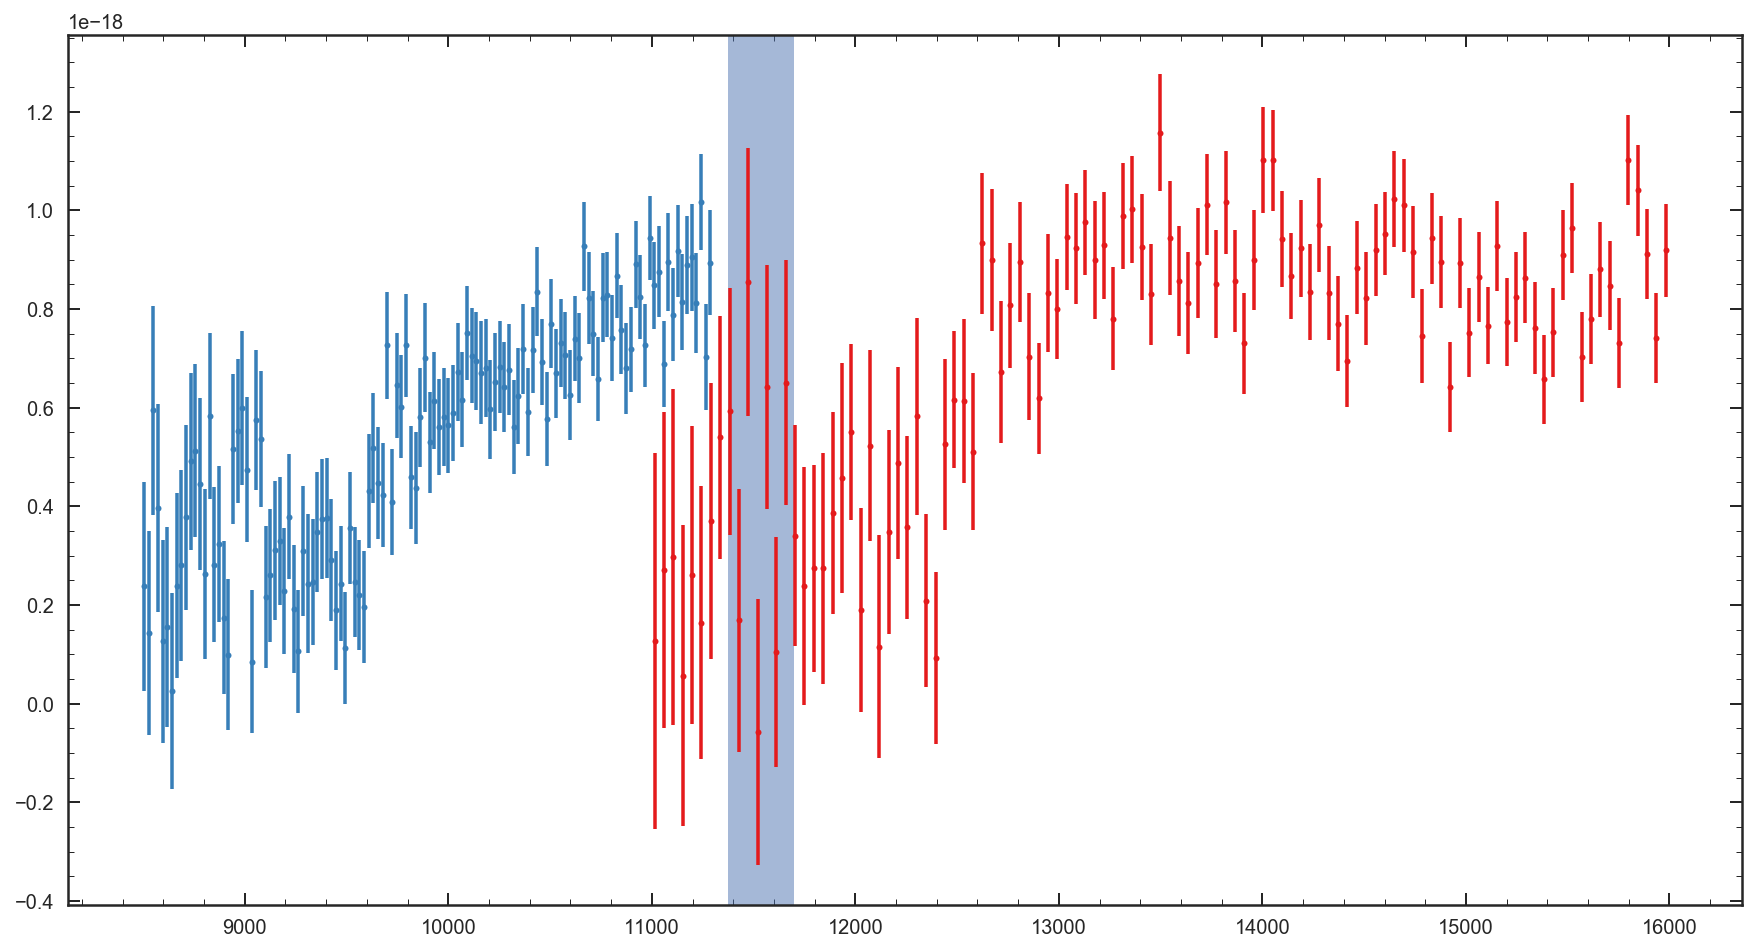

In [111]:
plt.figure(figsize=[15,8])

IDB = [U for U in range(len(Bwv)) if 8500 < Bwv[U] < 11300]
IDR = [U for U in range(len(Rwv)) if 11000 < Rwv[U] < 16000]

plt.errorbar(Bwv[IDB],Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
# plt.plot(Bwv, Smooth(sp.Bflx,sp.Bwv),'k', linewidth=3)
plt.errorbar(Rwv[IDR],Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.axvspan(11375,11700,alpha=0.5)

In [127]:
def Get_spec(beam):
#     xspec, yspec, yerr = beam.beam.optimal_extract(beam.grism.data['SCI'], bin=0, ivar=beam.ivar) #data

    xspec, yspec, yerr = beam.beam.optimal_extract(beam.grism.data['SCI'] - beam.contam, bin=0, ivar=beam.ivar) #data
    xspecc, yspecc, yerrc = beam.beam.optimal_extract(beam.contam, bin=0, ivar=beam.ivar)
    is_g102 = 'none'
    
    IDB = [U for U in range(len(Bwv)) if 8000 < Bwv[U] < 11300]
    IDR = [U for U in range(len(Rwv)) if 11000 < Rwv[U] < 16000]
    if max(xspec) < 16000:
        ispec = interp1d(xspec,yspec-yspecc)(Bwv)
        ierr = interp1d(xspec,np.sqrt(yerr**2 + yspecc**2))(Bwv)
        icontam = interp1d(xspec, yspecc)(Bwv)
        
        is_g102 = True

        flux = ispec / Bflt
        error = ierr / Bflt
        contam = icontam / Bflt
        
        error[flux**2 > 1] = 1E-15
        error[~(flux**2 > 0)] = 1E-15
        
        contam[flux**2 > 1] = 0
        contam[~(flux**2 > 0)] = 0
        
        flux[flux**2 > 1] = 0
        flux[~(flux**2 > 0)] = 0
        
        mod = np.trapz(flux[IDB],Bwv[IDB])
        
        flux /= mod
        error /= mod
        contam /= mod
    else:
        ispec = interp1d(xspec,yspec - yspecc)(Rwv)       
        ierr = interp1d(xspec,np.sqrt(yerr**2 + yspecc**2))(Rwv)
        icontam = interp1d(xspec, yspecc)(Rwv)

        is_g102 = False

        flux = ispec / Rflt
        error = ierr / Rflt
        contam = icontam / Rflt

        error[flux**2 > 1] = 1E-16
        error[~(flux**2 > 0)] = 1E-16
        
        contam[flux**2 > 1] = 0
        contam[~(flux**2 > 0)] = 0
                
        flux[flux**2 > 1] = 0
        flux[~(flux**2 > 0)] = 0
        
        mod = np.trapz(flux[IDR],Bwv[IDR])
        
        flux /= mod
        error /= mod
        contam /= mod
        
    return flux, error, is_g102, contam


In [170]:
Bsps= []
Bers = []
Bcon = []
Rsps= []
Rers = []
Rcon = []

for i in grp.beams:
    s,e,flg,contam = Get_spec(i)
    if flg:
        Bsps.append(s)
        Bers.append(e)
        Bcon.append(contam)
    else:
        Rsps.append(s)
        Rers.append(e)
        Rcon.append(contam)
        
Bsps = np.array(Bsps)
Bers = np.array(Bers)
Bcon = np.array(Bcon)
Rsps = np.array(Rsps)
Rers = np.array(Rers)
Rcon = np.array(Rcon)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:598: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:599: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/pytho

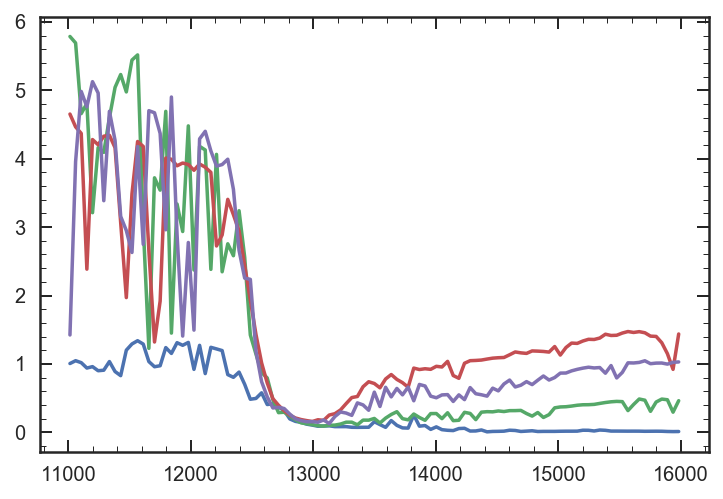

In [129]:
for i in range(len(Rcon)):
    plt.plot(Rwv[IDR],Rcon[i][IDR]**2/ ( Rers[i][IDR]**2 - Rcon[i][IDR]**2))    


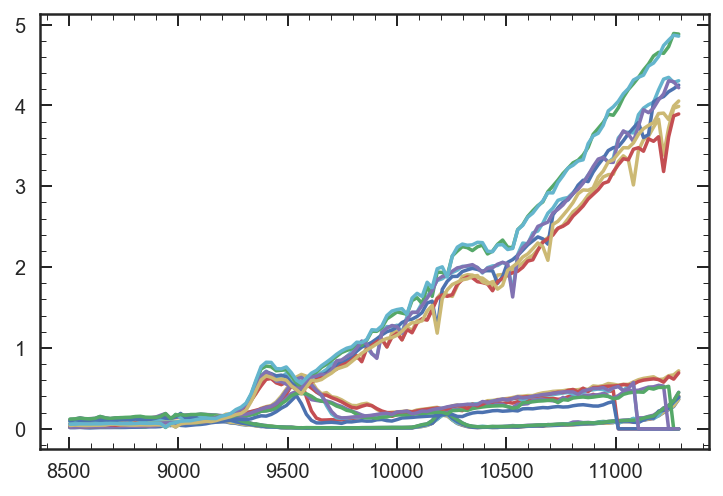

In [131]:
for i in range(len(Bcon)):
    plt.plot(Bwv[IDB],Bcon[i][IDB]**2/ (Bers[i][IDB]**2 - Bcon[i][IDB]**2))  

In [175]:
Bstk, Bser = Stack(Bwv,Bsps,Bers,Bcon)
Rstk, Rser = Stack(Rwv,Rsps[1:],Rers[1:],Rcon[1:])


<ErrorbarContainer object of 3 artists>

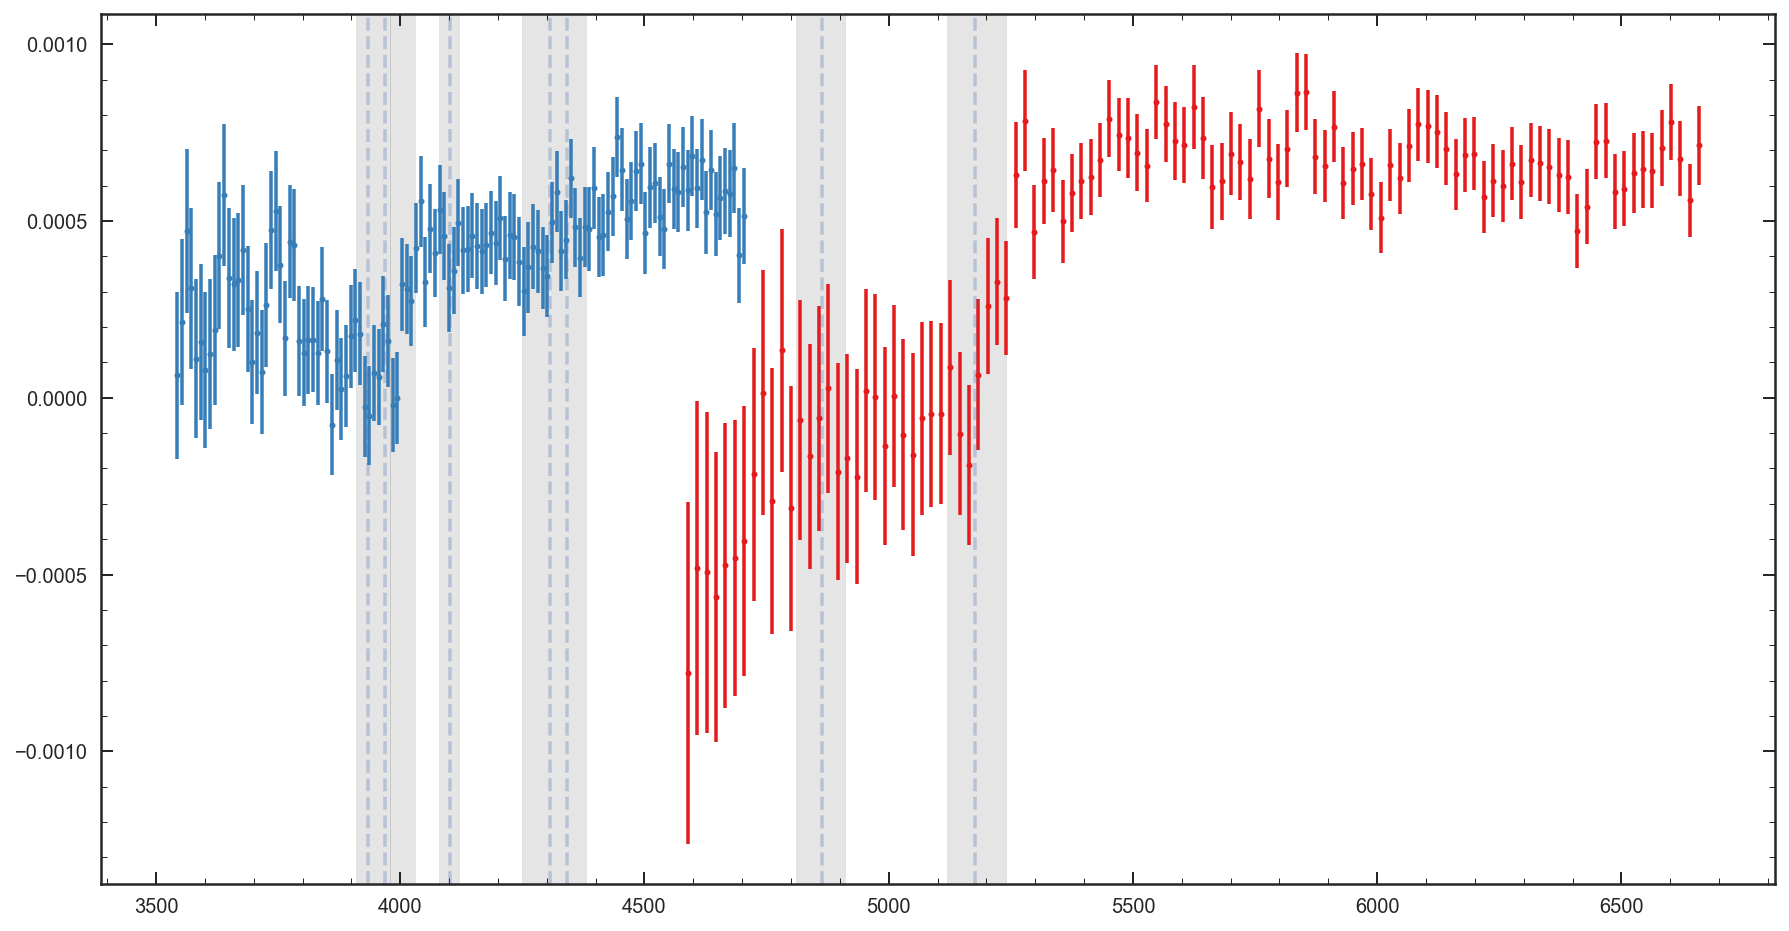

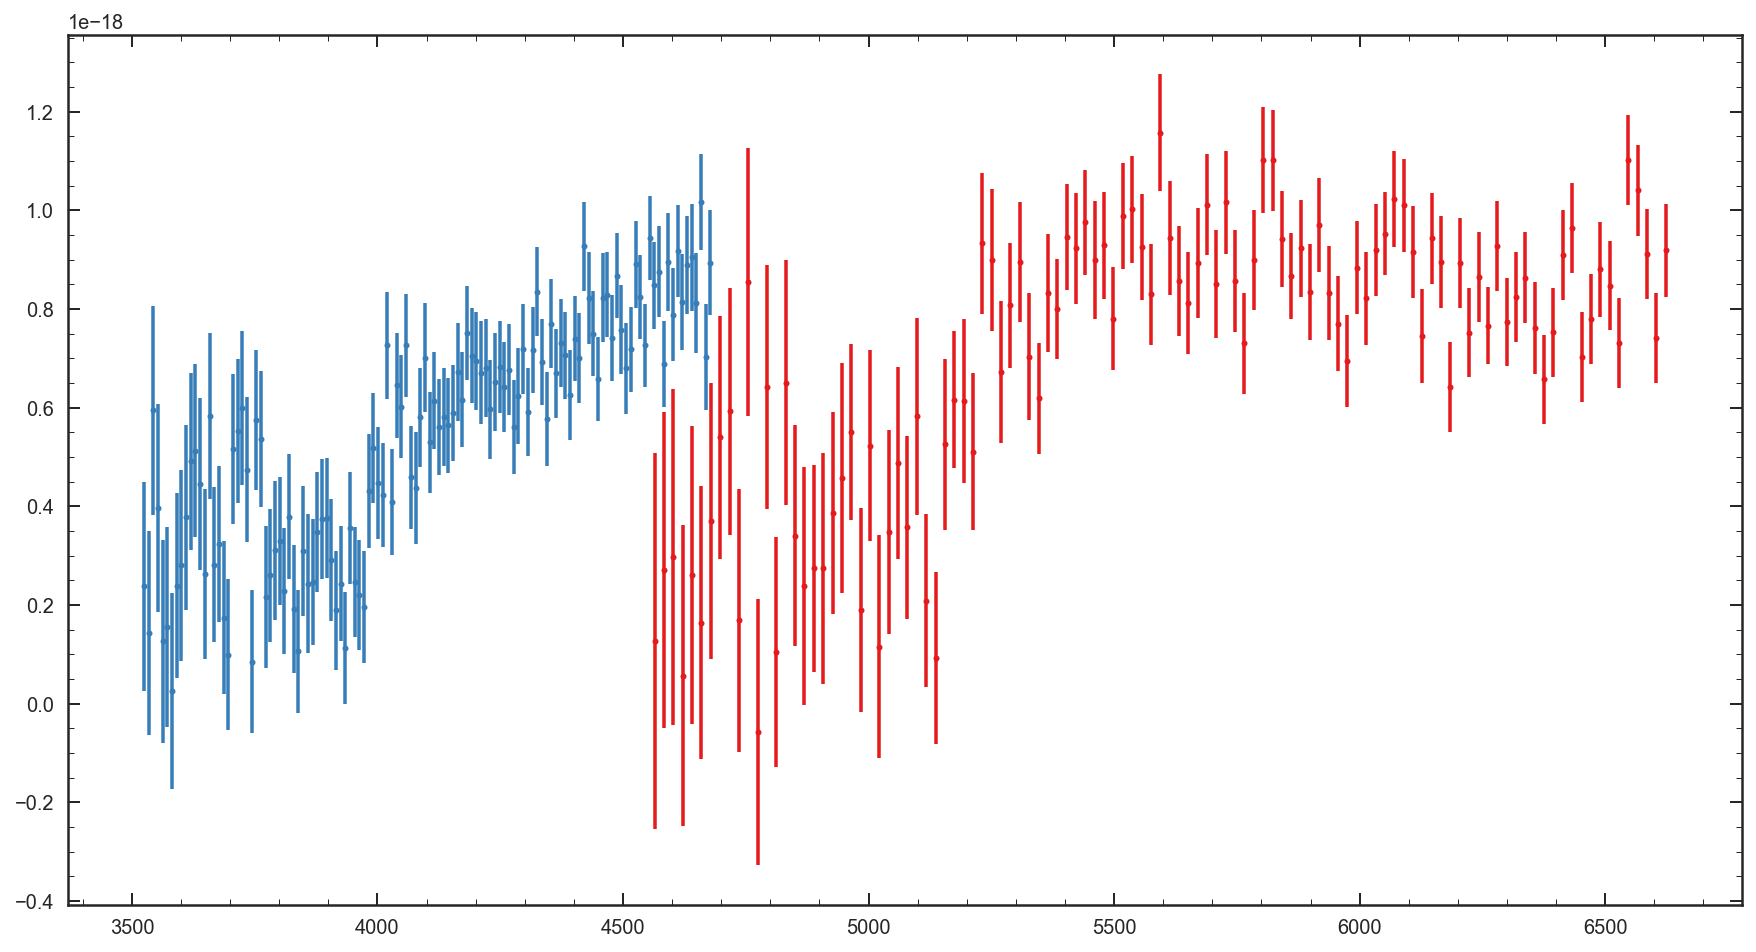

In [176]:
plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB]/(2.4),Bstk[IDB],Bser[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR]/(2.4),Rstk[IDR],Rser[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
# plt.text(3890,3.6,'Ca HK',fontsize=20)
# plt.text(4080,3.6,'H$\delta$',fontsize=20)
# plt.text(4275,3.6,'G+H$\gamma$',fontsize=20)
# plt.text(4830,3.6,'H$\\beta$',fontsize=20)
# plt.text(5160,5.6,'Mgb',fontsize=20)
# plt.axvspan(11375,11700,alpha=0.5)

# plt.figure(figsize=[15,8])
# plt.errorbar(Bwv[IDB]/(2.413),Bstk[IDB],Bser[IDB],
#             linestyle='None', marker='o', markersize=3, color='#377eb8')
# plt.errorbar(Rwv[IDR]/(2.413),Rstk2[IDR],Rser2[IDR],
#             linestyle='None', marker='o', markersize=3, color='#e41a1c')
# # plt.axvspan(11375,11700,alpha=0.5)

# plt.ylim(0,3E-3)

plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB]/(2.413),Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR]/(2.413),Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
# plt.axvspan(11375,11700,alpha=0.5)



/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


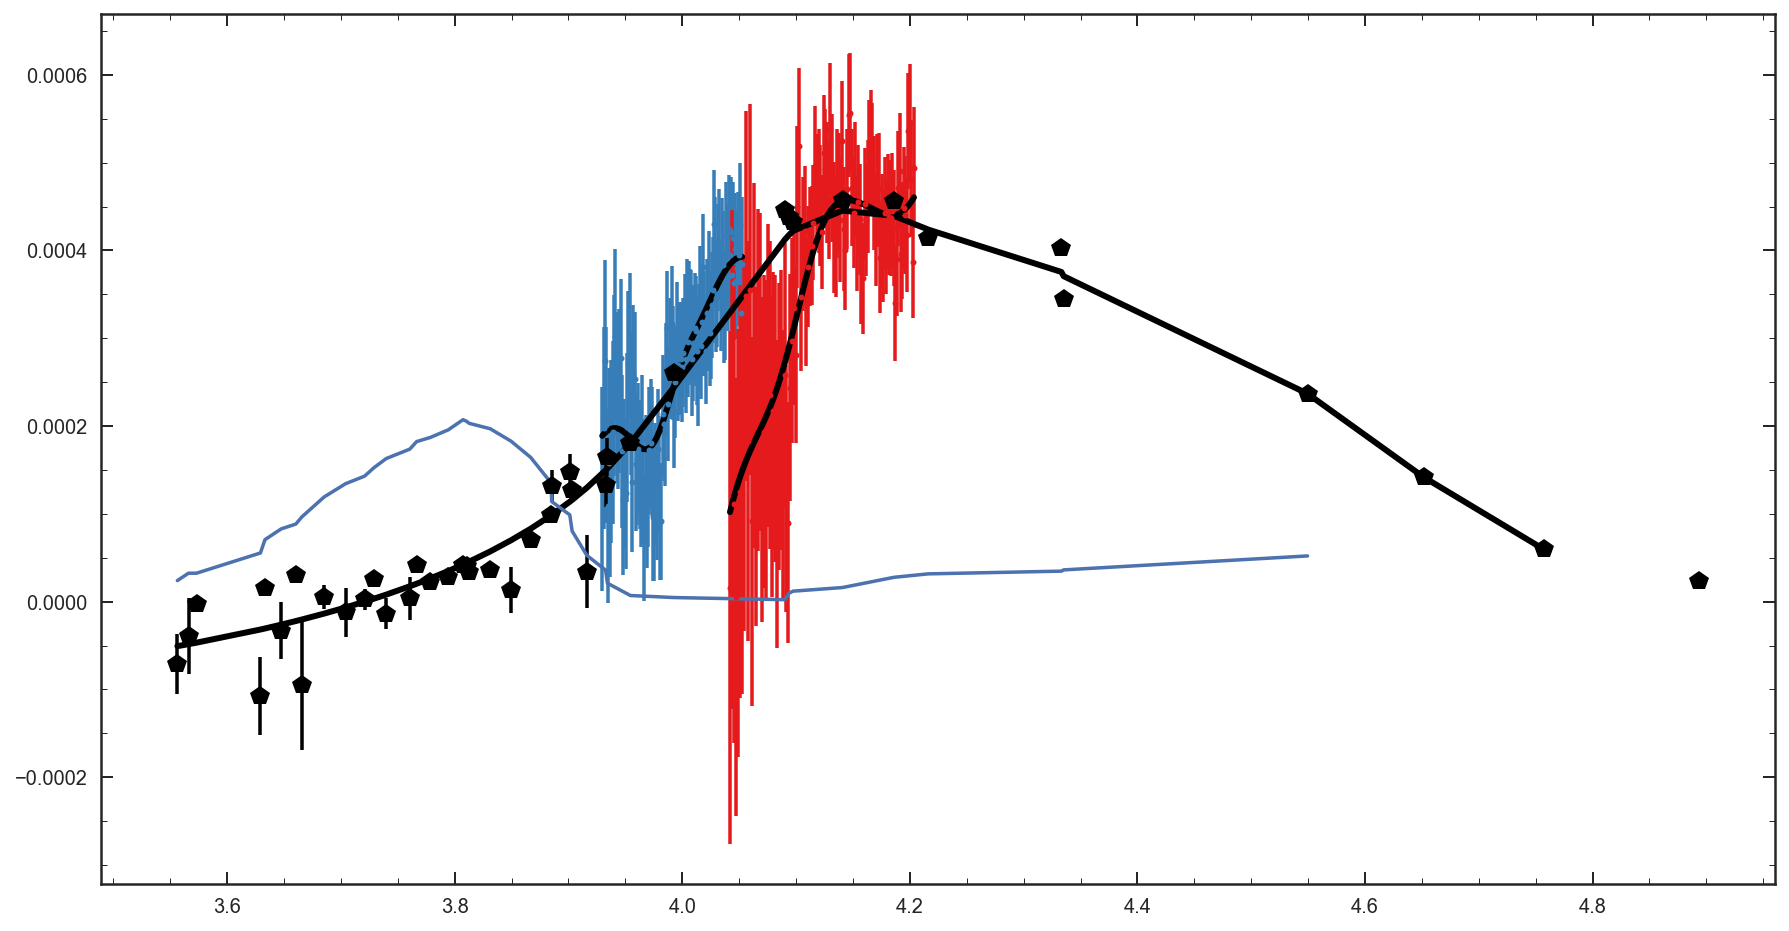

In [92]:
Pwv, Pflx, Perr, Pnum = np.load('../phot/GSD_40623_phot.npy')
def Smooth(f,x):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    fx = ksmooth.locpoly(x,f,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

plt.figure(figsize=[15,8])
plt.errorbar(np.log10(Bwv[IDB]),Bstk[IDB]*.8,Bser[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.plot(np.log10(Bwv[IDB]), Smooth(Bstk[IDB], Bwv[IDB])*.8,'k', linewidth=3)

plt.errorbar(np.log10(Rwv[IDR]),Rstk[IDR]*.9,Rser[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Rwv[IDR]), Smooth(Rstk[IDR], Rwv[IDR])*.9,'k', linewidth=3)
plt.errorbar(np.log10(Pwv), Pflx*5E14, Perr*5E14,
            linestyle='None', marker='p', markersize=10, color='k')
plt.plot(np.log10(Pwv[np.argsort(Pwv)]), Smooth(Pflx[np.argsort(Pwv)]*5E14, Pwv[np.argsort(Pwv)]),'k', linewidth=3)

# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
# plt.axvline(4862.68,linestyle='--', alpha=.3)
# plt.axvline(5176.7,linestyle='--', alpha=.3)
# plt.axvspan(3910, 3980, color='k', alpha=.1)
# plt.axvspan(3980, 4030, color='k', alpha=.1)
# plt.axvspan(4080, 4120, color='k', alpha=.1)
# plt.axvspan(4250, 4380, color='k', alpha=.1)
# plt.axvspan(4810, 4910, color='k', alpha=.1)
# plt.axvspan(5120, 5240, color='k', alpha=.1)



In [42]:
grp.beams.beam.cutout_from_full_image()

AttributeError: 'list' object has no attribute 'beam'

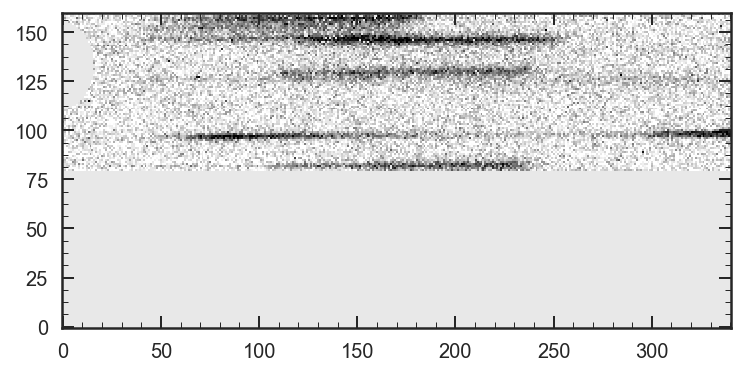

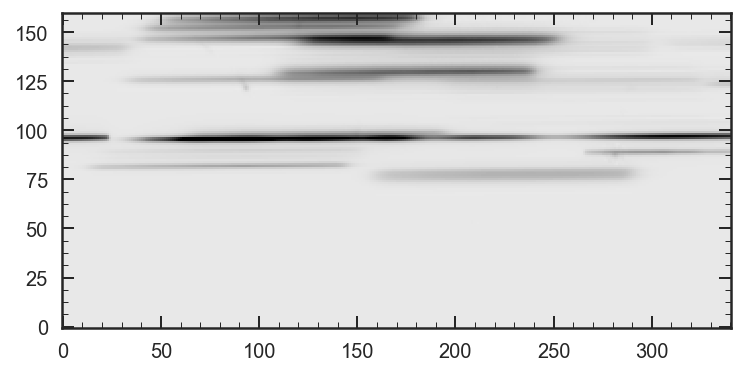

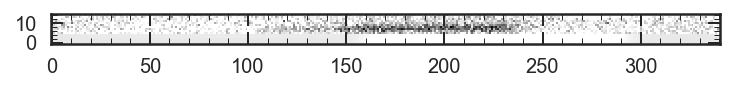

In [66]:
plt.figure()
plt.imshow(grp.beams[-3].grism.data['SCI'], interpolation='none', vmin=-0.02, vmax=0.2, origin='lower',cmap='gray_r')
plt.figure()
plt.imshow(grp.beams[-3].contam, interpolation='none', vmin=-0.02, vmax=0.2, origin='lower',cmap='gray_r')
plt.figure()
plt.imshow(grp.beams[-3].grism.data['SCI'][75:90] - grp.beams[-3].contam[75:90], interpolation='none', vmin=-0.02, vmax=0.2, origin='lower',cmap='gray_r')

In [76]:
xspec, yspec, yerr = grp.beams[-3].beam.optimal_extract(grp.beams[-3].grism.data['SCI'][75:90], bin=0, ivar=grp.beams[-3].ivar[75:90]) #data



`data` (15,341) must have the same shape as the data array (160,341)
            


TypeError: 'bool' object is not iterable